 ## Глава 2: Загрузка квантованной модели

 ### Содержание главы

 В этой главе мы:



 *   Поймем, как работает квантование.

 *   Изучим преимущества и недостатки использования различных типов данных (FP16, BF16, FP32).

 *   Познакомимся с концепцией вычислений со смешанной точностью.

 *   Используем BitsAndBytes для квантования предварительно обученной модели во время ее загрузки.

 ### Настройка окружения

In [1]:
# Если вы используете Colab
!pip install datasets bitsandbytes trl


In [2]:
# Если вы используете Jupyter Template от runpod.io
#!pip install datasets bitsandbytes trl transformers peft huggingface-hub accelerate safetensors pandas matplotlib


 ### Импорт библиотек

In [3]:
import numpy as np
import torch
import torch.nn as nn
from accelerate import init_empty_weights
from accelerate.utils.modeling import find_tied_parameters, get_mixed_precision_context_manager
from accelerate.utils.operations import convert_outputs_to_fp32
from bitsandbytes.nn import Linear8bitLt, Linear4bit, LinearFP4, LinearNF4
from collections import Counter
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer, AutoConfig
from transformers.integrations.bitsandbytes import get_keys_to_not_convert
from types import MethodType
from matplotlib import pyplot as plt


 ### Цель квантования

 Мы квантуем модели, чтобы уменьшить их объем в памяти. Мы можем легко сократить размер модели до четверти или восьмой части от исходного размера. Однако имейте в виду, что чем сильнее квантуется модель (т.е. чем меньше бит используется для представления ее весов), тем больше вероятность отрицательного влияния на ее производительность.

 ### Предварительные сведения о типах данных

 | Тип | Название | Количество бит | Псевдоним |
 |---|---|---|---|
 | FP32 | Число с плавающей запятой | 32 | Полная точность |
 | BF16 | Brain Float | 16 | Половинная точность |
 | FP16 | Число с плавающей запятой | 16 | Половинная точность |
 | INT8 | Целое число | 8 | 8-битное квантование |
 | FP4 | Число с плавающей запятой | 4 | 4-битное квантование |
 | NF4 | Normal Float | 4 | 4-битное квантование |



 ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/type_sizes.png?raw=True)

 <center>Рисунок 2.1 - Сравнение размеров типов данных</center>



 ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/model_sizes.png?raw=True)

 <center>Рисунок 2.2 - Представление одной и той же модели с использованием различных типов данных</center>

 ### Основы квантования

In [4]:
torch.manual_seed(11)
weights = torch.randn(1000) * .07
weights.min(), weights.max()


(tensor(-0.2066), tensor(0.2097))

In [5]:
n_bins = 4
bins = torch.linspace(weights.min(), weights.max(), n_bins+1)
bin_width = bins[1]-bins[0]
bins, bin_width


(tensor([-0.2066, -0.1026,  0.0015,  0.1056,  0.2097]), tensor(0.1041))

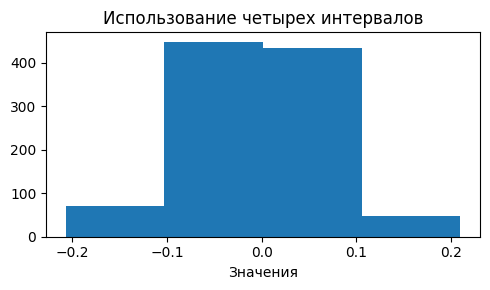

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
counts, _, _ = ax.hist(weights, bins=bins)
ax.set_xlabel('Значения')
ax.set_title('Использование четырех интервалов')
fig.tight_layout()


In [7]:
bin_indexes = (weights.view(-1, 1) > bins).to(torch.int).argmin(dim=1) - 1
print(weights[:20])
print(bin_indexes[:20])


tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048,  0.0099, -0.0367,
        -0.0174, -0.0368,  0.2025, -0.0416,  0.0918,  0.0247, -0.0921, -0.0006,
         0.0174,  0.1101, -0.1148, -0.1115])
tensor([1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 0, 0])


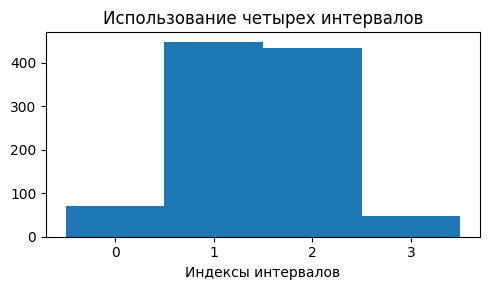

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
counts, _, _ = ax.hist(bin_indexes, bins=np.arange(n_bins+1)-.5)
ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Индексы интервалов')
ax.set_title('Использование четырех интервалов')
fig.tight_layout()




 $$

 \Large

 \text{n_bins}=2^{\text{n_bits}} \implies \text{n_bits} = \log_2({\text{n_bins}})

 $$



 <center>Уравнение 2.1 - Количество бит в зависимости от количества интервалов</center>

In [9]:
bin_values = bins[:-1]
first_bin = bin_values[0]
bin_values


tensor([-0.2066, -0.1026,  0.0015,  0.1056])



 $$

 \Large

 \text{approx_value} = \text{bin_index} * \text{bin_width} + \text{first_bin}

 $$



 <center>Уравнение 2.2 - Восстановление (приближенного) исходного значения</center>

In [10]:
torch.arange(0, n_bins) * bin_width + first_bin


tensor([-0.2066, -0.1026,  0.0015,  0.1056])

In [11]:
approx_values = bin_indexes * bin_width + first_bin
print(approx_values[:20])


tensor([-0.1026,  0.0015, -0.1026,  0.0015, -0.1026, -0.2066,  0.0015, -0.1026,
        -0.1026, -0.1026,  0.1056, -0.1026,  0.0015,  0.0015, -0.1026, -0.1026,
         0.0015,  0.1056, -0.2066, -0.2066])


In [12]:
print(weights[:20])


tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048,  0.0099, -0.0367,
        -0.0174, -0.0368,  0.2025, -0.0416,  0.0918,  0.0247, -0.0921, -0.0006,
         0.0174,  0.1101, -0.1148, -0.1115])


In [13]:
import torch.nn as nn
mse_fn = nn.MSELoss()
mse_fn(approx_values, weights).sqrt()


tensor(0.0615)

In [14]:
def quantize(weights, n_bits=8):
    assert n_bits <= 16, "Использование большего количества бит может привести к очень медленному выполнению и/или сбоям."
    n_bins = 2**n_bits
    bins = torch.linspace(weights.min(), weights.max(), n_bins+1)
    first_bin = bins[0]
    bin_width = bins[1]-bins[0]
    bin_indexes = (weights.view(-1, 1) > bins).to(torch.int).argmin(dim=1) - 1
    return bin_indexes, bin_width, first_bin

def dequantize(bin_indexes, bin_width, first_bin):
    approx_values = bin_indexes * bin_width + first_bin
    return approx_values


In [15]:
for n_bits in [2, 4, 8, 16]:
    res = quantize(weights, n_bits=n_bits)
    approx_values = dequantize(*res)
    print(f'{n_bits}-битное квантование:')
    print(approx_values[:6])
    print(weights[:6])
    print(mse_fn(approx_values, weights).sqrt())
    print('\n')


2-битное квантование:
tensor([-0.1026,  0.0015, -0.1026,  0.0015, -0.1026, -0.2066])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0615)


4-битное квантование:
tensor([-0.0505,  0.0535, -0.0505,  0.0015, -0.0245, -0.1286])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0152)


8-битное квантование:
tensor([-0.0359,  0.0714, -0.0261,  0.0080, -0.0131, -0.1058])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0010)


16-битное квантование:
tensor([-0.0359,  0.0718, -0.0248,  0.0085, -0.0128, -0.1049])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0001)




 ****

 **ОТСТУПЛЕНИЕ: Распределение весов в линейных слоях Phi-3**



 На следующих графиках показано распределение весов большого линейного слоя `qkv_proj` в блоке самовнимания Phi-3. Другие слои, такие как `o_proj`, также расположенные в блоке самовнимания, а также `gate_up_proj` и `down_proj` в блоке MLP, имеют очень похожее распределение весов. Этот слой присутствует в каждом из 32 блоков декодера (что указано числом в квадратных скобках). Вы заметите, что эти миллионы весов сконцентрированы в очень узком диапазоне. Однако есть и несколько выбросов, поэтому каждый подграфик также содержит фактический диапазон наблюдаемых весов в соответствующем слое.



 ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/self_attn.qkv_proj.png?raw=True)

 <center>Рисунок 2.5 - Распределение весов в слоях Phi-3</center>



 ****

 ### Веса с половинной точностью (FP16)

In [16]:
fp16_weights = weights.to(torch.float16)
print(fp16_weights[:6])
print(weights[:6])


tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048],
       dtype=torch.float16)
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])


In [17]:
print(mse_fn(fp16_weights, weights).sqrt())


tensor(1.4244e-05)


 #### Пограничные случаи

In [18]:
torch.manual_seed(14)
tiny_values = torch.randn(1000)*1e-5
fp16_tiny_values = tiny_values.to(torch.float16)
mse_fn(fp16_tiny_values, tiny_values)


tensor(2.8526e-16)

In [19]:
print(tiny_values[155:160])
print(fp16_tiny_values[155:160])


tensor([-2.7241e-06,  1.1441e-05,  3.7199e-06, -1.1252e-06, -2.4735e-08])
tensor([-2.7418e-06,  1.1444e-05,  3.6955e-06, -1.1325e-06, -0.0000e+00],
       dtype=torch.float16)


In [20]:
torch.manual_seed(19)
large_values = torch.randn(1000)*1e5
fp16_large_values = large_values.to(torch.float16)
print(large_values[:5])
print(fp16_large_values[:5])


tensor([155074.0938,  64881.6602,   2729.5815, -40790.6562,  68846.7188])
tensor([    inf,  64896.,   2730., -40800.,     inf], dtype=torch.float16)


In [21]:
fp16_info = torch.finfo(torch.float16)
fp16_info


finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)

In [22]:
smallest_subnormal = fp16_info.smallest_normal * 2**-10
smallest_subnormal


5.960464477539063e-08

 ### Brain Float (BF16)

In [23]:
bf16_info = torch.finfo(torch.bfloat16)
print(bf16_info)
print(fp16_info)


finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)
finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)


In [24]:
fp32_info = torch.finfo(torch.float32)
fp32_info


finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

In [25]:
x = torch.tensor([0.555555555])
torch.set_printoptions(precision=9)
print(x)
print(x.to(torch.float16))
print(x.to(torch.bfloat16))
torch.set_printoptions(precision=4)


tensor([0.555555582])
tensor([0.555664062], dtype=torch.float16)
tensor([0.554687500], dtype=torch.bfloat16)


 | Тип | Точность | Субнормальные | Мин. | Макс. |
 |---|---|---|---|---|
 | FP32 | e-08 | e-45 | e-38 | e+38 |
 | BF16 | e-03  | Н/Д | e-38 | e+38 |
 | FP16 | e-04  | e-08  | e-05 | e+04 |

 ### Загрузка моделей

 ****

 **Итог раздела "Загрузка моделей"**

 *   Если ваш GPU поддерживает, используйте `torch.bfloat16` вместо `torch.float16` для всех операций с 16-битной точностью.

     ```python
     supported = torch.cuda.is_bf16_supported(including_emulation=False)
     dtypes16 = (torch.bfloat16 if supported else torch.float16)
     ```

 *   При загрузке предварительно обученной модели всегда явно указывайте `torch_dtype`.

     ```python
     model = AutoModelForCausalLM.from_pretrained(repo_id, device_map='cuda:0', torch_dtype=torch.float32)
     ```

 ****

In [26]:
def get_parm_dtypes(iterable, top_k=3):
    return Counter([p.dtype for p in iterable]).most_common(top_k)


In [27]:
from huggingface_hub import snapshot_download

# Download entire repository
snapshot_download(
    repo_id="facebook/opt-350m",
    local_dir="./opt-350m-model",
    ignore_patterns=["*.h5", "*.ot", "*.msgpack"],  # Skip unnecessary formats
    local_dir_use_symlinks=False
)

# Load from local directory
model_dir = "./opt-350m-model"

model = AutoModelForCausalLM.from_pretrained(model_dir, device_map='cuda:0')
print(model.get_memory_footprint()/1e6)   
print(get_parm_dtypes(model.parameters()))


/home/loschilov_aa/.conda/envs/pytorchbook/lib/python3.10/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

1324.785664
[(torch.float32, 388)]


In [28]:
# !wget https://huggingface.co/facebook/opt-350m/resolve/main/pytorch_model.bin
# !ls -la pytorch_model.bin


In [29]:
state_dict = torch.load('opt-350m-model/pytorch_model.bin')
get_parm_dtypes(iter(state_dict.values()))


[(torch.float16, 388)]

In [30]:
model = AutoModelForCausalLM.from_pretrained(model_dir, 
                                             device_map='cuda:0',
                                             torch_dtype=torch.float32)


`torch_dtype` is deprecated! Use `dtype` instead!


In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)
batch = tokenizer(['This is a simple test'], return_tensors='pt')
batch['labels'] = batch['input_ids']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch = {k: v.to(device) for k, v in batch.items()}


In [32]:
out = model(**batch)
out.loss


tensor(3.8001, device='cuda:0', grad_fn=<NllLossBackward0>)

 #### Модели с половинной точностью (16 бит)

In [33]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
dtype16 = (torch.bfloat16 if supported else torch.float16)
dtype16


torch.bfloat16

In [34]:
model.to(dtype16)
print(model.get_memory_footprint()/1e6)
get_parm_dtypes(model.parameters())


662.392832


[(torch.bfloat16, 388)]

In [35]:
model = AutoModelForCausalLM.from_pretrained(model_dir, 
                                             device_map='cuda:0',
                                             torch_dtype=dtype16)
print(model.get_memory_footprint()/1e6)
print(get_parm_dtypes(model.parameters()))


662.392832
[(torch.bfloat16, 388)]


In [36]:
out = model(**batch)
out.loss


tensor(3.7930, device='cuda:0', grad_fn=<NllLossBackward0>)

 ### Смешанная точность

In [37]:
class MixedModel(nn.Module):
    def __init__(self, dtype):
        super().__init__()
        self.a = nn.Linear(1000, 1000, dtype=dtype)
        self.b = nn.Linear(1000, 1000, dtype=dtype)
        
    def forward(self, x):
        return self.b(self.a(x))


In [38]:
mixed32 = MixedModel(torch.float32)
mixed32.to('cuda')


MixedModel(
  (a): Linear(in_features=1000, out_features=1000, bias=True)
  (b): Linear(in_features=1000, out_features=1000, bias=True)
)

In [39]:
%timeit mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))


121 μs ± 204 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
mixed16 = MixedModel(torch.float16)
mixed16.to('cuda')


MixedModel(
  (a): Linear(in_features=1000, out_features=1000, bias=True)
  (b): Linear(in_features=1000, out_features=1000, bias=True)
)

In [41]:
%timeit mixed16(torch.randn(1000, 1000, dtype=torch.float16, device='cuda'))


50.2 μs ± 6.19 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [42]:
with torch.autocast(device_type="cuda", dtype=torch.float16):
    %timeit mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))


52.4 μs ± 3.82 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [43]:
with torch.autocast(device_type="cuda", dtype=torch.float16):
    res16 = mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))
    
res32 = res16.float()


In [44]:
autocast_context = torch.autocast(device_type="cuda", dtype=torch.float16)
# исходный метод forward
model_forward_func = mixed32.forward.__func__
# оборачиваем метод контекстным менеджером
new_forward = autocast_context(model_forward_func)
# присваиваем обернутый метод обратно модели
mixed32.forward = MethodType(new_forward, mixed32)


In [45]:
res = mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))
res.dtype


torch.float16

In [46]:
mixed32.forward = MethodType(convert_outputs_to_fp32(mixed32.forward.__func__), mixed32)


In [47]:
res = mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))
res.dtype


torch.float32

In [48]:
%timeit mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))


64.8 μs ± 9.49 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


 ### Библиотека BitsAndBytes

 [BitsAndBytes](https://huggingface.co/docs/bitsandbytes/main/en/index) — это основной пакет для квантования. Из его документации:



 "*bitsandbytes обеспечивает доступ к большим языковым моделям посредством k-битного квантования для PyTorch. bitsandbytes предоставляет три основные функции для значительного снижения потребления памяти при выводе и обучении:*



 *   *8-битные оптимизаторы используют блочное квантование для сохранения 32-битной производительности при малой доле стоимости памяти.*

 *   *LLM.Int() или 8-битное квантование позволяет выполнять вывод больших языковых моделей, используя только половину необходимой памяти и без какого-либо ухудшения производительности. Этот метод основан на по-векторном квантовании для квантования большинства признаков в 8 бит и отдельной обработке выбросов с помощью 16-битного матричного умножения.*

 *   *QLoRA или 4-битное квантование позволяет обучать большие языковые модели с использованием нескольких методов экономии памяти, которые не компрометируют производительность. Этот метод квантует модель до 4 бит и вставляет небольшой набор обучаемых весов низкоранговой адаптации (LoRA), чтобы обеспечить обучение.*"

In [49]:
bnb_config = BitsAndBytesConfig()
bnb_config


BitsAndBytesConfig {
  "_load_in_4bit": false,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": false,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

 #### 8-битное квантование

 "*LLM.int8() — это метод квантования, который не снижает производительность, что делает вывод больших моделей более доступным. Ключевая идея заключается в извлечении выбросов из входных данных и весов и их умножении в 16-битном формате. Все остальные значения умножаются в 8-битном формате и квантуются в Int8 перед тем, как быть деквантованными обратно в 16 бит. Результаты 16-битного и 8-битного умножения объединяются для получения окончательного выхода.*"



 Источник: [8-bit quantization](https://huggingface.co/docs/bitsandbytes/en/reference/nn/linear8bit)



 ****

 **Итог раздела "8-битное квантование"**

 *   Загрузите 8-битную квантованную модель несколькими строками кода:

     ```python

     bnb_config = BitsAndBytesConfig(load_in_8bit=True)

     model = AutoModelForCausalLM.from_pretrained(repo_id,

                                                  device_map='cuda:0',

                                                  torch_dtype=torch.float32,

                                                  quantization_config=bnb_config)

     ```

     *   Квантование изменяет тип по умолчанию неквантованных слоев на `torch.float16`, если мы явно не предоставим аргумент `torch_dtype` при вызове метода `from_pretrained()`.

 *   8-битное квантование заменяет все линейные слои, кроме:

     *   слоев со связанными (общими) весами;

     *   последнего слоя модели;

     *   любого слоя с именем `lm_head`.

 *   Если вы хотите пропустить дополнительные модули, используйте аргумент конфигурации `llm_int8_skip_modules` и обязательно включите вручную слои со связанными весами, чтобы избежать ошибок.

 *   Вычисления (внутри квантованных слоев) происходят в `torch.float16`.

 ****

In [50]:
bnb_config_q8 = BitsAndBytesConfig(load_in_8bit=True)
model_q8 = AutoModelForCausalLM.from_pretrained(model_dir,
                                                device_map='cuda:0',
                                                quantization_config=bnb_config_q8)
print(model_q8.get_memory_footprint()/1e6)
print(get_parm_dtypes(model_q8.parameters()))


359.354368
[(torch.float16, 242), (torch.int8, 146)]


In [51]:
# Возможно, вы не получите NaN, это зависит от среды
out = model_q8(**batch)
out.loss


tensor(3.8339, device='cuda:0', grad_fn=<NllLossBackward0>)

In [52]:
model_q8_32 = AutoModelForCausalLM.from_pretrained(model_dir, 
                                                device_map='cuda:0',
                                                quantization_config=bnb_config_q8,
                                                torch_dtype=torch.float32)
print(model_q8_32.get_memory_footprint()/1e6)
print(get_parm_dtypes(model_q8_32.parameters()))


415.670272
[(torch.float32, 242), (torch.int8, 146)]


In [53]:
out = model_q8_32(**batch)
out.loss


/home/loschilov_aa/.conda/envs/pytorchbook/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


tensor(3.8012, device='cuda:0', grad_fn=<NllLossBackward0>)

 ##### Квантованные линейные слои

In [54]:
dec_layer = model_q8_32.model.decoder.layers[0]
dec_layer


OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
    (v_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
    (q_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
    (out_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear8bitLt(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear8bitLt(in_features=4096, out_features=1024, bias=True)
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [55]:
q8_layer = dec_layer.self_attn.k_proj
q8_layer


Linear8bitLt(in_features=1024, out_features=1024, bias=True)

In [56]:
q8_state = q8_layer.state_dict()
q8_state


OrderedDict([('weight',
              tensor([[ -67, -113,  -89,  ...,   65,  -16,  -87],
                      [  60,  120,   90,  ...,  -50,   32,   80],
                      [  47,  127,   86,  ...,  -34,    8,   90],
                      ...,
                      [ -65,   65,   34,  ...,  -64,   35,   64],
                      [  57,   67,   21,  ...,   63,  -64,  -64],
                      [ -64,   63,  -11,  ...,  -64,   34,   63]], device='cuda:0',
                     dtype=torch.int8)),
             ('bias',
              tensor([-0.0134,  0.0082,  0.0161,  ..., -0.0242, -0.0150,  0.0203],
                     device='cuda:0')),
             ('SCB',
              tensor([0.1250, 0.1252, 0.1250,  ..., 0.1252, 0.1250, 0.1254], device='cuda:0')),
             ('weight_format', tensor(0, dtype=torch.uint8))])

In [57]:
print(model.model.decoder.embed_tokens)
print(model.lm_head)


Embedding(50272, 512, padding_idx=1)
Linear(in_features=512, out_features=50272, bias=False)


In [58]:
torch.allclose(model.model.decoder.embed_tokens.weight, 
               model.lm_head.weight)


True

In [59]:
config = AutoConfig.from_pretrained('facebook/opt-350m')

config.tie_word_embeddings, find_tied_parameters(model)


(True, [['lm_head.weight', 'model.decoder.embed_tokens.weight']])

In [60]:
with init_empty_weights(): # загружает только мета-тензоры
    empty_model = AutoModelForCausalLM.from_config(config)

empty_model.lm_head.weight


Parameter containing:
tensor(..., device='meta', size=(50272, 512), dtype=torch.float16,
       requires_grad=True)

In [61]:
skip_modules = get_keys_to_not_convert(empty_model)
skip_modules


['model.decoder.embed_tokens', 'lm_head']

In [62]:
for module in skip_modules:
    print(f'{module}: {next(model_q8_32.get_submodule(module).parameters()).dtype}')


model.decoder.embed_tokens: torch.float32
lm_head: torch.float32


 #### Параметр `llm_int8_skip_modules`

 Если у вашей модели есть связанные веса, и вы решили использовать собственный список модулей для пропуска, вы должны добавить один из связанных слоев в свой список. Если вы этого не сделаете, может возникнуть следующее исключение:



 ***

 `AttributeError: 'Parameter' object has no attribute 'SCB'`

 ***



 ```python

 # Эта конфигурация ВЫЗОВЕТ исключение

 # при попытке загрузить веса для связанного слоя

 # bnb_config_skip = BitsAndBytesConfig(load_in_8bit=True,

 #                                      llm_int8_skip_modules=['o_proj'])



 # Эта конфигурация работает нормально, потому что

 # связанный слой, lm_head, находится в списке

 bnb_config_skip = BitsAndBytesConfig(

         load_in_8bit=True,

         llm_int8_skip_modules=['o_proj', 'lm_head'])



 model_skip = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",

                                                   device_map='cuda:0',

                                                   torch_dtype=torch.float32,

                                                   quantization_config=bnb_config_skip)

 ```

 ##### 8-битные слои

 "*Чтобы квантовать линейный слой, следует сначала загрузить исходные веса fp16 / bf16 в модуль Linear8bitLt, затем вызвать int8_module.to("cuda") для квантования весов fp16.*"



 Источник: [8-bit quantization](https://huggingface.co/docs/bitsandbytes/en/reference/nn/linear8bit)

In [63]:
n_in = 10
n_out = 10

torch.manual_seed(11)
fp_layer = nn.Linear(n_in, n_out)

int8_layer = Linear8bitLt(n_in, n_out, has_fp16_weights=False)

int8_layer.load_state_dict(fp_layer.state_dict())
int8_layer.state_dict()


OrderedDict([('weight',
              tensor([[-0.2220, -0.0085,  0.3072, -0.2097,  0.0531,  0.1224,  0.0525, -0.2350,
                        0.0456,  0.2687],
                      [-0.1459,  0.1786, -0.1443, -0.0233,  0.1689,  0.0015, -0.2514,  0.1644,
                        0.1920,  0.1678],
                      [ 0.2346,  0.1411,  0.2128,  0.0519,  0.2147, -0.2786, -0.0433, -0.0364,
                       -0.1504,  0.0823],
                      [ 0.2388, -0.2134, -0.1620, -0.1023,  0.2433, -0.2680,  0.3099, -0.1933,
                       -0.0471, -0.0391],
                      [-0.1273,  0.2197, -0.0136, -0.1938, -0.1746,  0.0404,  0.0711, -0.1730,
                        0.0539, -0.1992],
                      [-0.0051,  0.1373, -0.0267, -0.0907, -0.0107,  0.1108, -0.1566,  0.0172,
                        0.2075, -0.0028],
                      [ 0.2082, -0.2857, -0.2640, -0.1436,  0.1704,  0.1908, -0.2350,  0.1187,
                       -0.0568,  0.0916],
                 

In [64]:
int8_layer = int8_layer.to(0) # Квантование происходит здесь
int8_state = int8_layer.state_dict()
int8_state


OrderedDict([('weight',
              tensor([[ -92,   -4,  127,  -87,   22,   51,   22,  -97,   19,  111],
                      [ -74,   90,  -73,  -12,   85,    1, -127,   83,   97,   85],
                      [ 107,   64,   97,   24,   98, -127,  -20,  -17,  -69,   38],
                      [  98,  -87,  -66,  -42,  100, -110,  127,  -79,  -19,  -16],
                      [ -74,  127,   -8, -112, -101,   23,   41, -100,   31, -115],
                      [  -3,   84,  -16,  -56,   -7,   68,  -96,   11,  127,   -2],
                      [  93, -127, -117,  -64,   76,   85, -104,   53,  -25,   41],
                      [ 123, -127,   23,   79,   11,  -79,  -24,  -39,  102,  117],
                      [ -51, -127,  -41,  -71,  110,  122,   67,  -11, -125,    9],
                      [ -50,    1,  -60,  -13,   73,  127,  106,  -70,   84,   84]],
                     device='cuda:0', dtype=torch.int8)),
             ('bias',
              tensor([ 0.1269,  0.2999,  0.0252, -0.038

 #### 4-битное квантование

 "*QLoRA — это метод тонкой настройки, который квантует модель до 4 бит и добавляет набор весов низкоранговой адаптации (LoRA) к модели, настраивая их через квантованные веса. Этот метод также вводит новый тип данных — 4-битный NormalFloat (LinearNF4) в дополнение к стандартному типу данных Float4 (LinearFP4). LinearNF4 — это тип данных квантования для нормально распределенных данных и может улучшить производительность.*"

 Источник: [4-bit quantization](https://huggingface.co/docs/bitsandbytes/en/reference/nn/linear4bit)

 ****
 
 **Итог раздела "4-битное квантование"**

 *   Максимально эффективно используйте 4-битную квантованную модель, применяя тип normal float (NF4) и двойное квантование.

     ```python

     supported = torch.cuda.is_bf16_supported(including_emulation=False)

     compute_dtype = (torch.bfloat16 if supported else torch.float32)

     nf4_config = BitsAndBytesConfig(

        load_in_4bit=True,

        bnb_4bit_quant_type="nf4",

        bnb_4bit_use_double_quant=True,

        bnb_4bit_compute_dtype=compute_dtype

     )

     model = AutoModelForCausalLM.from_pretrained(repo_id,

                                                  device_map='cuda:0',

                                                  torch_dtype=torch.float32,

                                                  quantization_config=nf4_config)

     ```

 *   Вычисления (внутри квантованных слоев) происходят в указанном типе (`bnb_4bit_compute_dtype`):

     FP32 лучше, чем BF16, который лучше, чем FP16.

 ****

In [65]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
compute_dtype = (torch.bfloat16 if supported else torch.float32)

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=compute_dtype
)


 **Скрытая жизнь типов данных (`Dtypes`)**

 | Обычная модель | Квантованная модель |
 |---|---|
 | ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/type_flow_regular.png?raw=True) | ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/type_flow_qt.png?raw=True) |
 | <center>Рисунок 2.6 - Поток типов данных в обычной модели</center> | <center>Рисунок 2.7 - Поток типов данных в квантованной модели</center> |

In [66]:
model_q4 = AutoModelForCausalLM.from_pretrained(model_dir, 
                                                device_map='cuda:0',
                                                torch_dtype=torch.float32,
                                                quantization_config=nf4_config)
print(model_q4.get_memory_footprint()/1e6)
print(get_parm_dtypes(model_q4.parameters()))


264.15104
[(torch.float32, 242), (torch.uint8, 146)]


In [67]:
out = model_q4(**batch)
out.loss


tensor(4.7086, device='cuda:0', grad_fn=<NllLossBackward0>)

In [68]:
dec_layer = model_q4.model.decoder.layers[0]
dec_layer


OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
    (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
    (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
    (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear4bit(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear4bit(in_features=4096, out_features=1024, bias=True)
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [69]:
q4_layer = dec_layer.self_attn.k_proj
q4_layer


Linear4bit(in_features=1024, out_features=1024, bias=True)

In [70]:
q4_layer.state_dict()


OrderedDict([('weight',
              tensor([[ 32],
                      [ 29],
                      [208],
                      ...,
                      [ 66],
                      [ 34],
                      [172]], device='cuda:0', dtype=torch.uint8)),
             ('bias',
              tensor([-0.0134,  0.0082,  0.0161,  ..., -0.0242, -0.0150,  0.0203],
                     device='cuda:0')),
             ('weight.absmax',
              tensor([230, 230,  30,  ...,   1,  26, 191], device='cuda:0',
                     dtype=torch.uint8)),
             ('weight.quant_map',
              tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
                       0.0796,  0.1609,  0.2461,  0.3379,  0.4407,  0.5626,  0.7230,  1.0000],
                     device='cuda:0')),
             ('weight.nested_absmax',
              tensor([0.0077, 0.0142, 0.0153, 0.0138, 0.0399, 0.0409, 0.0417, 0.0426, 0.0053,
                      0.0053, 0.0053, 0.0053, 0

 ##### Сравнение слоев FP4 и NF4

In [71]:
n_in = 10
n_out = 10
torch.manual_seed(11)
fp16_layer = nn.Linear(n_in, n_out)
fp16_layer


Linear(in_features=10, out_features=10, bias=True)

In [72]:
fp4_layer = LinearFP4(n_in, n_out)
fp4_layer.load_state_dict(fp16_layer.state_dict())

nf4_model = LinearNF4(n_in, n_out)
nf4_model.load_state_dict(fp16_layer.state_dict())


<All keys matched successfully>

In [73]:
fp4_layer = fp4_layer.to(0) # Квантование происходит здесь
fp4_state = fp4_layer.state_dict()

fp4_state['weight.quant_map'], fp4_state['weight'].shape


(tensor([ 0.0000,  0.0052,  0.6667,  1.0000,  0.3333,  0.5000,  0.1667,  0.2500,
          0.0000, -0.0052, -0.6667, -1.0000, -0.3333, -0.5000, -0.1667, -0.2500],
        device='cuda:0'),
 torch.Size([50, 1]))

Text(0.5, 1.0, 'Квантование FP4')

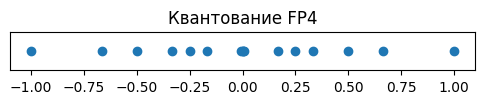

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, .5))
ax.scatter(x=sorted(fp4_state['weight.quant_map'].tolist()), y=[0]*16)
ax.set_yticks([])
ax.set_title('Квантование FP4')


In [75]:
nf4_model = nf4_model.to(0) # Квантование происходит здесь
nf4_state = nf4_model.state_dict()

nf4_state['weight.quant_map'], nf4_state['weight'].shape


(tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
          0.0796,  0.1609,  0.2461,  0.3379,  0.4407,  0.5626,  0.7230,  1.0000],
        device='cuda:0'),
 torch.Size([50, 1]))

Text(0.5, 1.0, 'Квантование NF4')

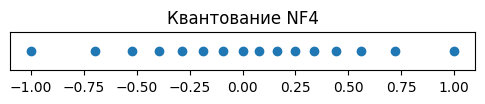

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, .5))
ax.scatter(x=sorted(nf4_state['weight.quant_map'].tolist()), y=[0]*16)
ax.set_yticks([])
ax.set_title('Квантование NF4')


 ### Что ждет в книге "Fine-Tuning LLMs"

 Поскольку огромные линейные слои заменяются их квантованными версиями для уменьшения объема памяти модели, возникает новая проблема. Эти квантованные слои нельзя легко обновить, что делает тонкую настройку почти невозможной. Может ли новый вид слоя стать решением этой загадки? Узнайте в следующей увлекательной главе книги "Fine-Tuning LLMs".